In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from src import detect_faces, show_bboxes
from PIL import Image
from PIL import ImageDraw

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 39.77it/s]


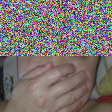

In [4]:
import os
import numpy as np

from copy import deepcopy
from tqdm import tqdm

for split in ['train_v0']:
    # for cls in [, '1_1_1']:
    for cls in ['1_1_1']:
        for image_file in tqdm(os.listdir(os.path.join("../data/facebank", split, cls))):
            try:
                img = Image.open(os.path.join("../data/facebank", split, cls, image_file))
            except IsADirectoryError:
                continue
            # img.verify()
            width, height = img.width, img.height
            try:
                bounding_boxes, landmarks = detect_faces(img)
                nose = (landmarks[-1][2], landmarks[-1][7])
            except:
                nose = (img.width // 2, img.height // 2)
            # show_bboxes(img, bounding_boxes, landmarks)
            
            
            if cls == '1_0_1':
                l, t, r, b = 0, nose[1], width, height
                new_cls = '1_0_1'
            else:
                l, t, r, b = 0, 0, width, nose[1]
                new_cls = '1_1_0'
            
            imarray = np.random.rand(112, 112, 3) * 255
            new_img = Image.fromarray(imarray.astype('uint8')).convert('RGB')
            cropped = img.crop((l, t, r, b))
            new_img.paste(cropped, (l, t))
            
            try:
                new_img.save(os.path.join("../data/facebank/train_v1", new_cls, 'cropped_' + image_file))
            except OSError:
                new_img.save(os.path.join("../data/facebank/train_v1", new_cls, 'cropped_' + image_file[:128] + image_file[-4:]))
                
            if cls == '1_1_1':
                l, t, r, b = 0, nose[1], width, height
                new_cls = '1_0_1'
                
                imarray = np.random.rand(112, 112, 3) * 255
                new_img = Image.fromarray(imarray.astype('uint8')).convert('RGB')
                cropped = img.crop((l, t, r, b))
                new_img.paste(cropped, (l, t))

                try:
                    new_img.save(os.path.join("../data/facebank/train_v1", new_cls, 'cropped_under_' + image_file))
                except OSError:
                    new_img.save(os.path.join("../data/facebank/train_v1", new_cls, 'cropped_under_' + image_file[:128] + image_file[-4:]))

new_img

In [ ]:
from collections import defaultdict

import os

from copy import deepcopy
from tqdm import tqdm

patches = defaultdict(list)

for split in ['train_v0']:
    for cls in ['1_0_1', '1_1_0']:
        for image_file in tqdm(os.listdir(os.path.join("../data/facebank", split, cls))[:50]):
            
            try:
                img = Image.open(os.path.join("../data/facebank", split, cls, image_file))
            except IsADirectoryError:
                continue
            # img.verify()
            
            width, height = img.width, img.height
            try:
                bounding_boxes, landmarks = detect_faces(img)
                nose = (landmarks[-1][2], landmarks[-1][7])
            except:
                nose = (img.width // 2, img.height // 2)
            # show_bboxes(img, bounding_boxes, landmarks)
            
            
            if cls == '1_0_1':
                l, t, r, b = 0, nose[1], width, height
            else:
                l, t, r, b = 0, 0, width, nose[1]
            
            img = img.crop((l, t, r, b))
            patches[cls].append(img)        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1416/1416 [00:32<00:00, 43.33it/s]


In [11]:
from itertools import product

for idx, pair in enumerate(product(patches['1_1_0'], patches['1_0_1'])):
    upper, lower = pair
    
    upper_size = upper.size
    lower_size = lower.size
    
    new_image = Image.new('RGB', (upper.width, upper.height + lower.height), (0, 0, 0))
    
    new_image.paste(upper, (0, 0))
    new_image.paste(lower, (0, upper.height))
    
    new_image.save(os.path.join("../data/facebank/train_v1/1_1_1", f"merged_{idx}.png"))


In [71]:
from collections import defaultdict

import os
import numpy as np

from copy import deepcopy
from tqdm import tqdm

MICROPHONE = "/workspace/InsightFace_Pytorch/data/FaceOcc/internet/microphone"

def white_to_transparency(img):
    pixdata = img.load()
    width, height = img.size
    
    for y in range(height):
        for x in range(width):
            if pixdata[x, y] == (0, 0, 0, 0):
                pixdata[x, y] = (255, 255, 255, 0)
    return img

microphones = []
for image_file in os.listdir(MICROPHONE):
    try:
        microphone = Image.open(os.path.join(MICROPHONE, image_file)).convert('RGBA')
        microphone = white_to_transparency(microphone)
    except Exception as e:
        print(e)
        continue
    microphones.append(microphone)

[Errno 21] Is a directory: '/workspace/InsightFace_Pytorch/data/FaceOcc/internet/microphone/.ipynb_checkpoints'


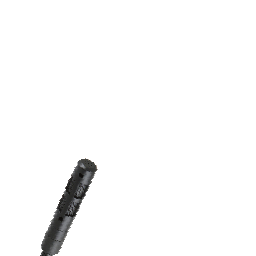

In [55]:
microphones[0]

In [95]:
import random

def trans_paste(fg_img,bg_img,alpha=1.0,box=(0,0)):
    
    fg_img_trans = Image.new("RGBA", fg_img.size)
    fg_img_trans = Image.blend(fg_img_trans, fg_img,alpha)
    bg_img.paste(fg_img_trans, box, fg_img_trans)
    
    return bg_img


pasted = []
for split in ['train_v0']:
    for cls in ['0_0_0']:
        for image_file in tqdm(os.listdir(os.path.join("../data/facebank", split, cls))):
            
            try:
                img = Image.open(os.path.join("../data/facebank", split, cls, image_file))
            except IsADirectoryError:
                continue
            # img.verify()
            
            width, height = img.width, img.height
            try:
                bounding_boxes, landmarks = detect_faces(img)
                bounding_boxes = bounding_boxes[-1]
                nose = (landmarks[-1][2], landmarks[-1][7])
            except Exception as e:
                bounding_boxes = [0, 0, 112, 112]
                landmarks = None
                nose = (img.width // 2, img.height // 2)
                
            
            l, t, r, b = 0, 0, width, nose[1]
            
            imarray = np.random.rand(112, 112, 3) * 255
            noise_img = Image.fromarray(imarray.astype('uint8')).convert('RGB')
            cropped = img.crop((l, t, r, b))
            noise_img.paste(cropped, (l, t))  
            
            try:
                noise_img.save(os.path.join("../data/facebank/train_v5/1_0_1", 'synthesized_' + image_file))
            except OSError:
                continue
            
            l, t, r, b = 0, int(nose[1]), width, height
            
            imarray = np.random.rand(112, 112, 3) * 255
            noise_img = Image.fromarray(imarray.astype('uint8')).convert('RGB')
            cropped = img.crop((l, t, r, b))
            noise_img.paste(cropped, (l, t))  
            
            try:
                noise_img.save(os.path.join("../data/facebank/train_v5/1_1_0", 'synthesized_' + image_file))
            except OSError:
                continue


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6016/6016 [00:54<00:00, 111.08it/s]


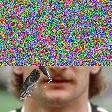

In [88]:
noise_img